In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nxcals.api.extraction.data.builders import *
from scipy.optimize import curve_fit
from cpymad.madx import Madx
from datetime import datetime
# from madxtools.plot_tool import *
# from madxtools.transfer_function import *
def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 18
    mpl.rcParams['axes.titlesize'] = 20  # Change the number for your preferred fontsize
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

In [73]:
start = "2023-10-31 17:36:00.000"
end = "2023-10-31 17:40:00.000"

selector = "CPS.USER.EAST3"

# Find the Brho through NXCALS

In [74]:
df = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("PR.BMEAS-B-ST/CycleSamples").build().toPandas()
df['avg_flattop_Gauss'] = df['samples'].apply(lambda x: round(np.mean(x["elements"][1000:1500]), 1)) # Hardcoded flattop time

rho = 70.0789
mean_flattop_Bfield = np.mean(df[df.selector==selector].avg_flattop_Gauss) # in Gauss
Brho = rho*mean_flattop_Bfield/10000 
print(f"Brho = {Brho}")

Brho = 49.070647358


In [75]:
df[df.selector==selector].avg_flattop_Gauss

1      7002.2
3      7002.2
5      7002.2
7      7002.2
9      7002.2
        ...  
121    7002.2
123    7002.2
125    7002.2
127    7002.2
129    7002.2
Name: avg_flattop_Gauss, Length: 61, dtype: float64

In [76]:
print(f"The mean B-field at flat-top was {mean_flattop_Bfield} [Gauss]")

The mean B-field at flat-top was 7002.2 [Gauss]


# Septa

In [77]:
df_smh57 = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("PE.SMH57/MEAS.PULSE").build().toPandas()

In [78]:
# Reset the index of the final DataFrame
df_smh57 = df_smh57[df_smh57.selector == selector].reset_index(drop=True)
print(f"SMH57 = {round(float(df_smh57.VALUE[0]),2)} [A]")

SMH57 = 5266.54 [A]


In [79]:
df_smh61 = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("PE.SMH61/MEAS.PULSE").build().toPandas()

In [80]:
# Reset the index of the final DataFrame
df_smh61 = df_smh61[df_smh61.selector == selector].reset_index(drop=True)
print(f"SMH61 = {round(float(df_smh61.VALUE[0]),3)} [A]")

SMH61 = 19.984 [A]


# Dipoles and correctors

In [81]:
# Initialize an empty DataFrame
df_dipoles = pd.DataFrame()

magnet_names = ["F61.BHZ025.A/MEAS.PULSE",
                "F61.BHZ025.B/MEAS.PULSE",
               "F61.BHZ033.A/MEAS.PULSE",
                "F61.BHZ033.B/MEAS.PULSE",
               "T08.BHZ005/MEAS.PULSE",
               "T08.BHZ044/MEAS.PULSE",
               "T08.BHZ047/MEAS.PULSE",
                "F61.DHZ013/MEAS.PULSE",
                "F61.DVT015/MEAS.PULSE",
                "T08.DHZ025/MEAS.PULSE",
                "T08.DVT057/MEAS.PULSE",
                "T08.DVT057/MEAS.PULSE",
                "T08.DHZ059/MEAS.PULSE"]

for magnet_name in magnet_names:
    df = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter(magnet_name).build().toPandas()
    df = df[['VALUE', 'acqStamp', 'selector']]

    # Add a new column for the corrector name
    df['magnet_name'] = magnet_name
    
    # Add a column with timestamp in datetime format
    df["timestamp"] = pd.to_datetime(df['acqStamp'], unit='ns')
    df.sort_values(by="timestamp", inplace=True)

    # Append the DataFrame from this iteration to the combined DataFrame
    df_dipoles = pd.concat([df_dipoles, df], ignore_index=True)

# Reset the index of the final DataFrame
df_dipoles = df_dipoles[df_dipoles.selector == selector].reset_index(drop=True)


In [82]:
df

VALUE             acqStamp        selector            magnet_name  \
6   31.568073  1698773764352000000  CPS.USER.EAST3  T08.DHZ059/MEAS.PULSE   
27  31.569523  1698773767952000000  CPS.USER.EAST3  T08.DHZ059/MEAS.PULSE   
38  31.568914  1698773771552000000  CPS.USER.EAST3  T08.DHZ059/MEAS.PULSE   
36  31.569054  1698773775152000000  CPS.USER.EAST3  T08.DHZ059/MEAS.PULSE   
58  31.568783  1698773778752000000  CPS.USER.EAST3  T08.DHZ059/MEAS.PULSE   
..        ...                  ...             ...                    ...   
29  31.568577  1698773985152000000  CPS.USER.EAST3  T08.DHZ059/MEAS.PULSE   
11  31.567703  1698773988752000000  CPS.USER.EAST3  T08.DHZ059/MEAS.PULSE   
1   31.568836  1698773992352000000  CPS.USER.EAST3  T08.DHZ059/MEAS.PULSE   
2   31.570332  1698773995952000000  CPS.USER.EAST3  T08.DHZ059/MEAS.PULSE   
60  31.568184  1698773999552000000  CPS.USER.EAST3  T08.DHZ059/MEAS.PULSE   

                 timestamp  
6  2023-10-31 17:36:04.352  
27 2023-10-31 17:36:07.952  
38 2023-10-31 17:36:11.552  
36 2023-10-31 17:36:15.152  
58 2023-10-31 17:36:18.752  
..                     ...  
29 2023-10-31 17:39:45.152  
11 2023-10-31 17:39:48.752  
1  2023-10-31 17:39:52.352  
2  2023-10-31 17:39:55.952  
60 2023-10-31 17:39:59.552  

[61 rows x 5 columns]

In [83]:
import numpy as np

def k1(current, magnet_type, Brho):
    
    A_Q74L = [0.0,
    5.000978,
    10.000304,
    50.002003,
    100.001404,
    150.001373,
    200.00238,
    250.005432,
    299.993652,
    350.001648,
    399.995728,
    449.994446,
    499.997375,
    549.999878,
    599.994873,
    650.004211,
    666.999146,
    699.991455,
    749.998169,
    799.996643]
    
    T_Q74L = [0.0,
    0.2619,
    0.492968,
    2.358847,
    4.710821,
    7.068205,
    9.426532,
    11.780794,
    14.131984,
    16.4773,
    18.814776,
    21.133094,
    23.416058,
    25.617934,
    27.638804,
    29.43015,
    29.981004,
    30.987122,
    32.347211,
    33.545971]
    
    L_Q74L = 0.74
    
    A_Q120C = [0.00,
    50.00,
    100.00,
    150.00,
    200.00,
    250.00,
    300.00,
    350.00,
    400.00,
    450.00,
    500.00,
    550.00,
    600.00,
    650.00]
    
    T_Q120C = [0.00,
    2.05,
    4.12,
    6.19,
    8.26,
    10.33,
    12.39,
    14.43,
    16.44,
    18.36,
    20.14,
    21.74,
    23.01,
    24.07]
    
    L_Q120C = 1.2
    
    A_QFL = [0,
    94.15,
    145.76,
    197.97,
    250.74,
    300.18,
    350.7,
    402,
    451.15,
    502.09,
    551.47]
    
    T_QFL = [0,
    4.86,
    7.48,
    10.158,
    12.875,
    15.377,
    17.81,
    20.045,
    21.844,
    23.217,
    24.445]
    
    L_QFL = 1.2
    
    A_QFS = [0,
    98.95,
    147.71,
    197.23,
    249.64,
    301.81,
    351.91,
    400.77,
    454.51,
    506.28,
    555.25]
    
    T_QFS = [0,
    3.462,
    5.158,
    6.875,
    8.686,
    10.48,
    12.14,
    13.57,
    14.79,
    15.75,
    16.49]
    
    L_QFS = 0.8
    
    A_Q200L = [0.0,
    5.0,
    10.0,
    50.0,
    100.0,
    150.0,
    200.0,
    250.0,
    300.0,
    350.0,
    400.0,
    450.0,
    500.0,
    540.0,
    600.0,
    650.0,
    700.0,
    750.0,
    800.0,
    850.0]
    
    T_Q200L = [0.0,
    0.20,
    0.38,
    1.85,
    3.69,
    5.54,
    7.39,
    9.23,
    11.08,
    12.91,
    14.74,
    16.54,
    18.28,
    19.58,
    21.34,
    22.57,
    23.57,
    24.38,
    25.08,
    25.67]
    
    L_Q200L = 2.0
    
    if magnet_type == "Q74L":
        measured_currents = A_Q74L
        measured_int_gradient = T_Q74L
        length = L_Q74L
        
    if magnet_type == "Q120C":
        measured_currents = A_Q120C
        measured_int_gradient = T_Q120C
        length = L_Q120C
        
    if magnet_type == "QFL":
        measured_currents = A_QFL
        measured_int_gradient = T_QFL
        length = L_QFL
        
    if magnet_type == "QFS":
        measured_currents = A_QFS
        measured_int_gradient = T_QFS
        length = L_QFS
        
    if magnet_type == "Q200L":
        measured_currents = A_Q200L
        measured_int_gradient = T_Q200L
        length = L_Q200L
        
    int_gradient = np.interp(current,measured_currents,measured_int_gradient)
    k1 = int_gradient / (length * Brho)
    
    return k1
    
def current(k, magnet_type, Brho):
    
    A_Q74L = [0.0,
    5.000978,
    10.000304,
    50.002003,
    100.001404,
    150.001373,
    200.00238,
    250.005432,
    299.993652,
    350.001648,
    399.995728,
    449.994446,
    499.997375,
    549.999878,
    599.994873,
    650.004211,
    666.999146,
    699.991455,
    749.998169,
    799.996643]
    
    T_Q74L = [0.0,
    0.2619,
    0.492968,
    2.358847,
    4.710821,
    7.068205,
    9.426532,
    11.780794,
    14.131984,
    16.4773,
    18.814776,
    21.133094,
    23.416058,
    25.617934,
    27.638804,
    29.43015,
    29.981004,
    30.987122,
    32.347211,
    33.545971]
    
    L_Q74L = 0.74
    
    A_Q120C = [0.00,
    50.00,
    100.00,
    150.00,
    200.00,
    250.00,
    300.00,
    350.00,
    400.00,
    450.00,
    500.00,
    550.00,
    600.00,
    650.00]
    
    T_Q120C = [0.00,
    2.05,
    4.12,
    6.19,
    8.26,
    10.33,
    12.39,
    14.43,
    16.44,
    18.36,
    20.14,
    21.74,
    23.01,
    24.07]
    
    L_Q120C = 1.2
    
    A_QFL = [0,
    94.15,
    145.76,
    197.97,
    250.74,
    300.18,
    350.7,
    402,
    451.15,
    502.09,
    551.47]
    
    T_QFL = [0,
    4.86,
    7.48,
    10.158,
    12.875,
    15.377,
    17.81,
    20.045,
    21.844,
    23.217,
    24.445]
    
    L_QFL = 1.2
    
    A_QFS = [0,
    98.95,
    147.71,
    197.23,
    249.64,
    301.81,
    351.91,
    400.77,
    454.51,
    506.28,
    555.25]
    
    T_QFS = [0,
    3.462,
    5.158,
    6.875,
    8.686,
    10.48,
    12.14,
    13.57,
    14.79,
    15.75,
    16.49]
    
    L_QFS = 0.8
    
    A_Q200L = [0.0,
    5.0,
    10.0,
    50.0,
    100.0,
    150.0,
    200.0,
    250.0,
    300.0,
    350.0,
    400.0,
    450.0,
    500.0,
    540.0,
    600.0,
    650.0,
    700.0,
    750.0,
    800.0,
    850.0]
    
    T_Q200L = [0.0,
    0.20,
    0.38,
    1.85,
    3.69,
    5.54,
    7.39,
    9.23,
    11.08,
    12.91,
    14.74,
    16.54,
    18.28,
    19.58,
    21.34,
    22.57,
    23.57,
    24.38,
    25.08,
    25.67]
    
    L_Q200L = 2.0
    
    if magnet_type == "Q74L":
        measured_currents = A_Q74L
        measured_int_gradient = T_Q74L
        length = L_Q74L
        
    if magnet_type == "Q120C":
        measured_currents = A_Q120C
        measured_int_gradient = T_Q120C
        length = L_Q120C
        
    if magnet_type == "QFL":
        measured_currents = A_QFL
        measured_int_gradient = T_QFL
        length = L_QFL
        
    if magnet_type == "QFS":
        measured_currents = A_QFS
        measured_int_gradient = T_QFS
        length = L_QFS
        
    if magnet_type == "Q200L":
        measured_currents = A_Q200L
        measured_int_gradient = T_Q200L
        length = L_Q200L
    
    int_grad = k*length * Brho
    current = np.interp(int_grad, measured_int_gradient, measured_currents)    
    
    return current


# For Dipoles and correctors of the T8 line

def angle(current, magnet_type, Brho):
    
    # Dipoles
    A_MCB = [0,50.13, 100.31, 150.72, 200.86, 250.19, 300.53, 350.88, 401.01, 450.36, 500.18, 550.91, 601.18, 650.55, 700.2, 750.92, 800.7, 850.1, 880.9]
    Bdl_MCB = [0, 0.4201, 0.8379, 1.2594, 1.6678, 2.08807, 2.49581, 2.88241, 3.1638, 3.38286, 3.5695, 3.7365, 3.89024, 4.02763, 4.1436, 4.23895, 4.32285, 4.39996, 4.44424]
    
    # Correctors
    A_CR200 = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
    Bdl_CR200 = [0, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150, 0.175, 0.199, 0.222, 0.242, 0.260, 0.275]
    
    A_MDXL150 = [0, 10, 20, 40, 50, 80, 100, 120, 150, 160, 180, 200, 220, 240]
    Bdl_MDXL150 = [0, 0.0159, 0.03175, 0.06352, 0.079425, 0.127135, 0.15889, 0.190535, 0.237695, 0.25322, 0.2839, 0.313115, 0.339, 0.361385]
    

    if magnet_type == "MCB":
        measured_currents = A_MCB
        measured_Bdl = Bdl_MCB
    
    if magnet_type == "CR200":
        measured_currents = A_CR200
        measured_Bdl = Bdl_CR200
        
    if magnet_type == "MDXL150":
        measured_currents = A_MDXL150
        measured_Bdl = Bdl_MDXL150
    
    Bdl = np.interp(current, measured_currents, measured_Bdl)
    angle = Bdl / Brho
    return angle # radians

def get_current_dipole(angle, magnet_type, Brho):

    # Dipoles
    A_MCB = [0,50.13, 100.31, 150.72, 200.86, 250.19, 300.53, 350.88, 401.01, 450.36, 500.18, 550.91, 601.18, 650.55, 700.2, 750.92, 800.7, 850.1, 880.9]
    Bdl_MCB = [0, 0.4201, 0.8379, 1.2594, 1.6678, 2.08807, 2.49581, 2.88241, 3.1638, 3.38286, 3.5695, 3.7365, 3.89024, 4.02763, 4.1436, 4.23895, 4.32285, 4.39996, 4.44424]
    
    # Correctors
    A_CR200 = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
    Bdl_CR200 = [0, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150, 0.175, 0.199, 0.222, 0.242, 0.260, 0.275]
    
    A_MDXL150 = [0, 10, 20, 40, 50, 80, 100, 120, 150, 160, 180, 200, 220, 240]
    Bdl_MDXL150 = [0, 0.0159, 0.03175, 0.06352, 0.079425, 0.127135, 0.15889, 0.190535, 0.237695, 0.25322, 0.2839, 0.313115, 0.339, 0.361385]
    

    if magnet_type == "MCB":
        measured_currents = A_MCB
        measured_Bdl = Bdl_MCB
    
    if magnet_type == "CR200":
        measured_currents = A_CR200
        measured_Bdl = Bdl_CR200
        
    if magnet_type == "MDXL150":
        measured_currents = A_MDXL150
        measured_Bdl = Bdl_MDXL150

    Bdl = angle * Brho  # Compute Bdl from the given angle and Brho
    current = np.interp(Bdl, measured_Bdl, measured_currents)  # Interpolate to find the corresponding current
    return current

In [84]:
keys = ["F61.BHZ025.A/MEAS.PULSE", "F61.BHZ025.B/MEAS.PULSE", "F61.BHZ033.A/MEAS.PULSE", "F61.BHZ033.B/MEAS.PULSE", "T08.BHZ005/MEAS.PULSE", "T08.BHZ044/MEAS.PULSE","T08.BHZ047/MEAS.PULSE",   
    "F61.DHZ013/MEAS.PULSE", "F61.DVT015/MEAS.PULSE", "T08.DHZ025/MEAS.PULSE", "T08.DVT026/MEAS.PULSE", "T08.DVT057/MEAS.PULSE", "T08.DHZ059/MEAS.PULSE"]
values = ["MCB","MCB","MCB","MCB","MCB","MCB","MCB","CR200", "CR200", "MDXL150",  "MDXL150",  "MDXL150",  "MDXL150"]

mapping = dict(zip(keys, values))

# Create a new column with angle

# Create a column with magnet type
df_dipoles["type"] = df_dipoles['magnet_name'].map(mapping)

# Apply the angle function to each row and add results as a new column
df_dipoles['angle'] = df_dipoles.apply(lambda row: angle(row['VALUE'], row.type, Brho*54/82), axis=1)

In [85]:
angle(600, 'MCB', Brho*54/82)

0.12027396835255705

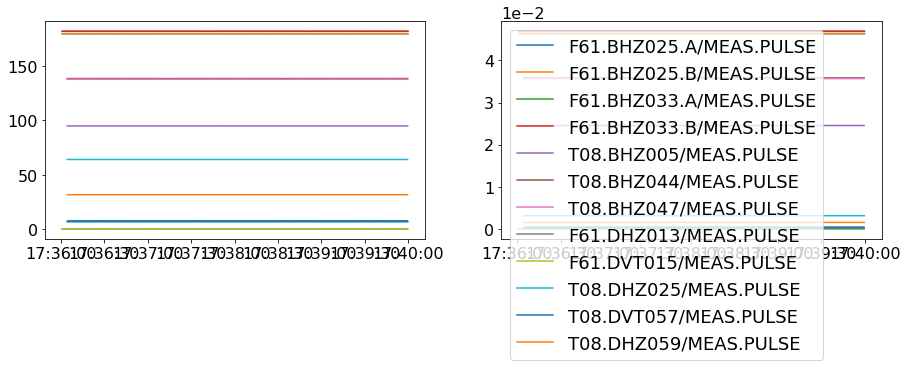

In [86]:
fig, ax = plt.subplots(1,2, figsize = (15,4))

for name in df_dipoles.magnet_name.unique():
    
    df_filtered = df_dipoles[ (df_dipoles.magnet_name == name)]
    ax[0].plot(df_filtered.timestamp, df_filtered.VALUE, label=name)
    ax[1].plot(df_filtered.timestamp, df_filtered.angle, label=name)

ax[1].legend()

In [87]:
print(start)
print(end)
print(selector)
print("")

for name in df_dipoles.magnet_name.unique():
    df_filtered = df_dipoles[(df_dipoles.magnet_name == name)]
    print(f"{name} {round(np.mean(df_filtered.angle),6)}")

2023-10-31 17:36:00.000
2023-10-31 17:40:00.000
CPS.USER.EAST3

F61.BHZ025.A/MEAS.PULSE 0.046353
F61.BHZ025.B/MEAS.PULSE 0.046353
F61.BHZ033.A/MEAS.PULSE 0.046913
F61.BHZ033.B/MEAS.PULSE 0.046913
T08.BHZ005/MEAS.PULSE 0.024551
T08.BHZ044/MEAS.PULSE 0.035843
T08.BHZ047/MEAS.PULSE 0.035679
F61.DHZ013/MEAS.PULSE 0.0
F61.DVT015/MEAS.PULSE 0.0
T08.DHZ025/MEAS.PULSE 0.003149
T08.DVT057/MEAS.PULSE 0.000341
T08.DHZ059/MEAS.PULSE 0.001551


In [88]:
print(start)
print(end)
print(selector)
print("")

for name in df_dipoles.magnet_name.unique():
    df_filtered = df_dipoles[(df_dipoles.magnet_name == name)]
    print(f"{name} {round(float(np.mean(df_filtered.VALUE)),2)} [A]")

2023-10-31 17:36:00.000
2023-10-31 17:40:00.000
CPS.USER.EAST3

F61.BHZ025.A/MEAS.PULSE 180.0 [A]
F61.BHZ025.B/MEAS.PULSE 180.0 [A]
F61.BHZ033.A/MEAS.PULSE 182.22 [A]
F61.BHZ033.B/MEAS.PULSE 182.22 [A]
T08.BHZ005/MEAS.PULSE 94.96 [A]
T08.BHZ044/MEAS.PULSE 138.62 [A]
T08.BHZ047/MEAS.PULSE 137.99 [A]
F61.DHZ013/MEAS.PULSE -0.0 [A]
F61.DVT015/MEAS.PULSE -0.0 [A]
T08.DHZ025/MEAS.PULSE 64.04 [A]
T08.DVT057/MEAS.PULSE 6.93 [A]
T08.DHZ059/MEAS.PULSE 31.57 [A]


In [89]:
(66 + 54.26)/2

60.129999999999995

# Quadrupoles

In [90]:
# Initialize an empty DataFrame
df_quadrupoles = pd.DataFrame()

magnet_names = ["F61.QFN007/MEAS.PULSE",
               "F61.QDN014/MEAS.PULSE",
               "F61.QFN021/MEAS.PULSE",
               "F61.QDN030/MEAS.PULSE",
               "T08.QFN021/MEAS.PULSE",
                "T08.QDN023/MEAS.PULSE",
                "T08.QDN061/MEAS.PULSE",
                "T08.QFN066/MEAS.PULSE",]

for magnet_name in magnet_names:
    df = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter(magnet_name).build().toPandas()
    df = df[['VALUE', 'acqStamp', 'selector']]

    # Add a new column for the corrector name
    df['magnet_name'] = magnet_name
    
    # Add a column with timestamp in datetime format
    df["timestamp"] = pd.to_datetime(df['acqStamp'], unit='ns')
    df.sort_values(by="timestamp", inplace=True)

    # Append the DataFrame from this iteration to the combined DataFrame
    df_quadrupoles = pd.concat([df_quadrupoles, df], ignore_index=True)

# Reset the index of the final DataFrame
df_quadrupoles = df_quadrupoles[df_quadrupoles.selector == selector].reset_index(drop=True)

In [91]:
keys = ["F61.QFN007/MEAS.PULSE",
       "F61.QDN014/MEAS.PULSE",
       "F61.QFN021/MEAS.PULSE",
       "F61.QDN030/MEAS.PULSE",
       "T08.QFN021/MEAS.PULSE",
        "T08.QDN023/MEAS.PULSE",
        "T08.QDN061/MEAS.PULSE",
        "T08.QFN066/MEAS.PULSE",]
values = ["Q74L","Q120C","QFL","QFS","QFL","QFL","Q200L","Q200L"]

mapping = dict(zip(keys, values))

# Create a new column with K1

# Create a column with magnet type
df_quadrupoles["type"] = df_quadrupoles['magnet_name'].map(mapping)

# Apply the k1 function to each row and add results as a new column
df_quadrupoles['k1'] = df_quadrupoles.apply(lambda row: k1(row['VALUE'], row.type, Brho=Brho) if row.magnet_name == "F61.QFN007/MEAS.PULSE" else k1(row['VALUE'], row.type, Brho), axis=1)

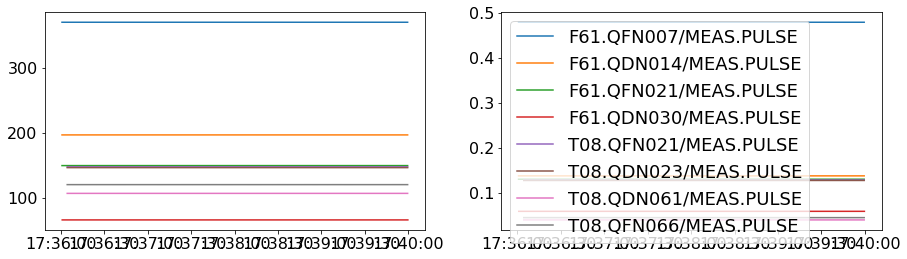

In [92]:
fig, ax = plt.subplots(1,2, figsize = (15,4))

for name in df_quadrupoles.magnet_name.unique():
    
    df_filtered = df_quadrupoles[ (df_quadrupoles.magnet_name == name)]
    ax[0].plot(df_filtered.timestamp, df_filtered.VALUE, label=name)
    ax[1].plot(df_filtered.timestamp, df_filtered.k1, label=name)

ax[1].legend()

In [93]:
print(start)
print(end)
print(selector)
print("")

for name in df_quadrupoles.magnet_name.unique():
    df_filtered = df_quadrupoles[(df_quadrupoles.magnet_name == name)]
    print(f"{name} {round(float(np.mean(df_filtered.VALUE)),3)} [A]")

2023-10-31 17:36:00.000
2023-10-31 17:40:00.000
CPS.USER.EAST3

F61.QFN007/MEAS.PULSE 370.058 [A]
F61.QDN014/MEAS.PULSE 197.182 [A]
F61.QFN021/MEAS.PULSE 150.103 [A]
F61.QDN030/MEAS.PULSE 66.751 [A]
T08.QFN021/MEAS.PULSE 148.261 [A]
T08.QDN023/MEAS.PULSE 146.96 [A]
T08.QDN061/MEAS.PULSE 107.472 [A]
T08.QFN066/MEAS.PULSE 120.893 [A]


In [94]:
print(start)
print(end)
print(selector)
print("")

for name in df_quadrupoles.magnet_name.unique():
    df_filtered = df_quadrupoles[(df_quadrupoles.magnet_name == name)]
    print(f"{name} {round(np.mean(df_filtered.k1),6)}")

2023-10-31 17:36:00.000
2023-10-31 17:40:00.000
CPS.USER.EAST3

F61.QFN007/MEAS.PULSE 0.47959
F61.QDN014/MEAS.PULSE 0.138293
F61.QFN021/MEAS.PULSE 0.130811
F61.QDN030/MEAS.PULSE 0.059492
T08.QFN021/MEAS.PULSE 0.129207
T08.QDN023/MEAS.PULSE 0.128073
T08.QDN061/MEAS.PULSE 0.040416
T08.QFN066/MEAS.PULSE 0.045476


# Presentation

In [95]:
print(start)
print(end)
print(selector)
print("")

d = {'name': [], 'angle': []}
df_dipole_avg = pd.DataFrame(data=d)
print("Dipoles avg angle [rad]")
for name in df_dipoles.magnet_name.unique():
    df_filtered = df_dipoles[(df_dipoles.magnet_name == name) & (df_dipoles.type == "MCB")]
    if not df_filtered.empty:
        print(f"{name} {round(np.mean(df_filtered.angle),6)}")
        d = {'name': [name], 'angle': [np.mean(df_filtered.angle)]}
        df = pd.DataFrame(data=d)
        df_dipole_avg = pd.concat([df_dipole_avg,df])
        

d = {'name': [], 'angle': []}
df_corrector_avg = pd.DataFrame(data=d)
print("")
print("Correctors avg angle [rad]")
for name in df_dipoles.magnet_name.unique():
    df_filtered = df_dipoles[(df_dipoles.magnet_name == name) & (df_dipoles.type != "MCB")]
    if not df_filtered.empty:
        print(f"{name} {round(np.mean(df_filtered.angle),6)}")
        d = {'name': [name], 'angle': [np.mean(df_filtered.angle)]}
        df = pd.DataFrame(data=d)
        df_corrector_avg = pd.concat([df_corrector_avg,df])

d = {'name': [], 'angle': []}
df_quadrupole_avg = pd.DataFrame(data=d)
print("")
print("Quadrupoles avg K1 [1/m^2]")
for name in df_quadrupoles.magnet_name.unique():
    df_filtered = df_quadrupoles[(df_quadrupoles.magnet_name == name)]
    print(f"{name} {round(np.mean(df_filtered.k1),6)}")
    d = {'name': [name], 'angle': [np.mean(df_filtered.k1)]}
    df = pd.DataFrame(data=d)
    df_quadrupole_avg = pd.concat([df_quadrupole_avg,df])
    
df_dipole_avg.set_index('name', inplace=True)
df_corrector_avg.set_index('name', inplace=True)
df_quadrupole_avg.set_index('name', inplace=True)

2023-10-31 17:36:00.000
2023-10-31 17:40:00.000
CPS.USER.EAST3

Dipoles avg angle [rad]
F61.BHZ025.A/MEAS.PULSE 0.046353
F61.BHZ025.B/MEAS.PULSE 0.046353
F61.BHZ033.A/MEAS.PULSE 0.046913
F61.BHZ033.B/MEAS.PULSE 0.046913
T08.BHZ005/MEAS.PULSE 0.024551
T08.BHZ044/MEAS.PULSE 0.035843
T08.BHZ047/MEAS.PULSE 0.035679

Correctors avg angle [rad]
F61.DHZ013/MEAS.PULSE 0.0
F61.DVT015/MEAS.PULSE 0.0
T08.DHZ025/MEAS.PULSE 0.003149
T08.DVT057/MEAS.PULSE 0.000341
T08.DHZ059/MEAS.PULSE 0.001551

Quadrupoles avg K1 [1/m^2]
F61.QFN007/MEAS.PULSE 0.47959
F61.QDN014/MEAS.PULSE 0.138293
F61.QFN021/MEAS.PULSE 0.130811
F61.QDN030/MEAS.PULSE 0.059492
T08.QFN021/MEAS.PULSE 0.129207
T08.QDN023/MEAS.PULSE 0.128073
T08.QDN061/MEAS.PULSE 0.040416
T08.QFN066/MEAS.PULSE 0.045476


Text(0.5, 1.0, 'Quadrupoles')

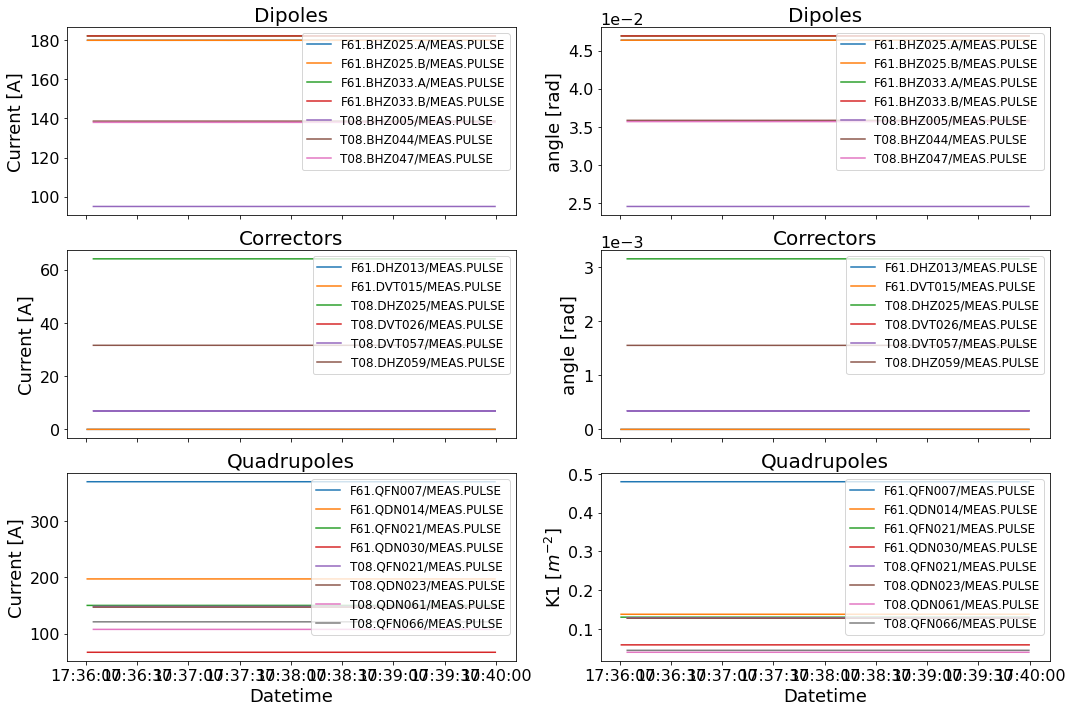

In [98]:
fig, ax = plt.subplots(3,2, figsize = (15,10), sharex=True, tight_layout=True)

fontsize = 12

dipole_names = ["F61.BHZ025.A/MEAS.PULSE",
                "F61.BHZ025.B/MEAS.PULSE",
               "F61.BHZ033.A/MEAS.PULSE",
                "F61.BHZ033.B/MEAS.PULSE",
               "T08.BHZ005/MEAS.PULSE",
               "T08.BHZ044/MEAS.PULSE",
               "T08.BHZ047/MEAS.PULSE"]

for name in dipole_names:
    
    df_filtered = df_dipoles[ (df_dipoles.magnet_name == name)]
    ax[0,0].plot(df_filtered.timestamp, df_filtered.VALUE, label=name)
    ax[0,1].plot(df_filtered.timestamp, df_filtered.angle, label=name)

ax[0,0].legend(fontsize=fontsize, loc="upper right")
ax[0,1].legend(fontsize=fontsize, loc="upper right")

corrector_names = ["F61.DHZ013/MEAS.PULSE",
                "F61.DVT015/MEAS.PULSE",
                "T08.DHZ025/MEAS.PULSE",
                "T08.DVT026/MEAS.PULSE",
                "T08.DVT057/MEAS.PULSE",
                "T08.DHZ059/MEAS.PULSE"]

for name in corrector_names:
    
    df_filtered = df_dipoles[ (df_dipoles.magnet_name == name)]
    ax[1,0].plot(df_filtered.timestamp, df_filtered.VALUE, label=name)
    ax[1,1].plot(df_filtered.timestamp, df_filtered.angle, label=name)

ax[1,0].legend(fontsize=fontsize, loc="upper right")
ax[1,1].legend(fontsize=fontsize, loc="upper right")


quadrupole_names = ["F61.QFN007/MEAS.PULSE",
                   "F61.QDN014/MEAS.PULSE",
                   "F61.QFN021/MEAS.PULSE",
                   "F61.QDN030/MEAS.PULSE",
                   "T08.QFN021/MEAS.PULSE",
                    "T08.QDN023/MEAS.PULSE",
                    "T08.QDN061/MEAS.PULSE",
                    "T08.QFN066/MEAS.PULSE",]

for name in quadrupole_names:
    
    df_filtered = df_quadrupoles[ (df_quadrupoles.magnet_name == name)]
    ax[2,0].plot(df_filtered.timestamp, df_filtered.VALUE, label=name)
    ax[2,1].plot(df_filtered.timestamp, df_filtered.k1, label=name)

ax[2,0].legend(fontsize=fontsize, loc="upper right")
ax[2,1].legend(fontsize=fontsize, loc="upper right")


ax[2,0].set_xlabel("Datetime")
ax[2,1].set_xlabel("Datetime")

ax[0,0].set_ylabel("Current [A]")
ax[1,0].set_ylabel("Current [A]")
ax[2,0].set_ylabel("Current [A]")

ax[0,1].set_ylabel(r"angle [rad]")
ax[1,1].set_ylabel(r"angle [rad]")
ax[2,1].set_ylabel(r"K1 [$m^{-2}$]")

# Titles
ax[0,0].set_title("Dipoles")
ax[0,1].set_title("Dipoles")

ax[1,0].set_title("Correctors")
ax[1,1].set_title("Correctors")

ax[2,0].set_title("Quadrupoles")
ax[2,1].set_title("Quadrupoles")

# Now that I have the values I can run them in a twiss

In [104]:
# Beam characteristics
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

# Initial conditions
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

#################################### Initialize MADX ############################################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,ANGLE, DELTAP, BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input("kQFN1 = "+str(df_quadrupole_avg.loc["F61.QFN007/MEAS.PULSE"].angle)+";")
madx.input("kQDN2 = "+str(-df_quadrupole_avg.loc["F61.QDN014/MEAS.PULSE"].angle)+";")
madx.input("kQFN3 = "+str(df_quadrupole_avg.loc["F61.QFN021/MEAS.PULSE"].angle)+";")
madx.input("kQDN4 = "+str(-df_quadrupole_avg.loc["F61.QDN030/MEAS.PULSE"].angle)+";")
madx.input("kQFN5 = "+str(df_quadrupole_avg.loc["T08.QFN021/MEAS.PULSE"].angle)+";")
madx.input("kQDN6 = "+str(-df_quadrupole_avg.loc["T08.QDN023/MEAS.PULSE"].angle)+";")
madx.input("kQDN7 = "+str(-df_quadrupole_avg.loc["T08.QDN061/MEAS.PULSE"].angle)+";")
madx.input("kQFN8 = "+str(df_quadrupole_avg.loc["T08.QFN066/MEAS.PULSE"].angle)+";")

############################################################################################################

madx.use(sequence="f61t8_op")


start_datetime = datetime.strptime(start, '%Y-%m-%d %H:%M:%S.%f')
formatted_start = start_datetime.strftime('%Y_%m_%d_%H_%M_%S')
end_datetime = datetime.strptime(end, '%Y-%m-%d %H:%M:%S.%f')
formatted_end = end_datetime.strftime('%Y_%m_%d_%H_%M_%S')


twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file="twiss_"+str(formatted_start)+"_to_"+str(formatted_end)+"_"+(selector.replace(".","_"))+".twiss").dframe()

In [107]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
from matplotlib.pyplot import cm
from pybt.tools.plotters import *
from pybt.tools.parsers import *
from matplotlib.patches import Ellipse, Rectangle, Arc

from scipy.io import loadmat
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.tools.plotters import *

def draw_aperture_circle(ax, twiss, aper):
  """
  Plot rectangles for apertures that have a type of "circle".

  Parameters:
  - twiss (DataFrame): DataFrame containing the Twiss parameters.
  - aper (str): Column name of the aperture size in the DataFrame.
  - ax (matplotlib.axes._subplots.AxesSubplot): Matplotlib axis to plot on.

  Returns:
  None
  """
  # Iterate through the rows of the twiss DataFrame
  for _, row in twiss[twiss[aper] > 0].iterrows():
    # Check if the aperture type is "circle"
    if row["apertype"] == "circle":
      # Set the facecolor to black
      facecolor = "k"
      # Plot a rectangle for the first half of the aperture
      _ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 1), row['l'], -1+row[aper], facecolor=facecolor))
      # Plot a rectangle for the second half of the aperture
      _ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], -1), row['l'], 1-row[aper], facecolor=facecolor))

def draw_aperture_rectangle(ax, twiss, aper):
		for _, row in twiss[twiss[aper] > 0].iterrows():
				if row["apertype"]=="rectangle":
						facecolor="k"
						_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 1), row['l'], -1+row[aper],facecolor=facecolor))
						_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], -1), row['l'], 1-row[aper],facecolor=facecolor))
						
def draw_aperture_rectcircle(axH, axV, twiss, aper_1, aper_2, aper_3):
		for _, row in twiss[twiss[aper_1] > 0].iterrows():
				if row["apertype"]=="rectcircle":
						facecolor="k"
						
						_ = axH.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 1), row['l'], -1+row[aper_1],facecolor="gray", alpha=0.5))
						_ = axH.add_patch(mpl.patches.Rectangle((row['s']-row['l'], -1), row['l'], 1-row[aper_1],facecolor="gray", alpha=0.5))
						_ = axH.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 1), row['l'], -1+row[aper_1]+row[aper_3],facecolor=facecolor))
						_ = axH.add_patch(mpl.patches.Rectangle((row['s']-row['l'], -1), row['l'], 1-row[aper_1]-row[aper_3],facecolor=facecolor))
						_ = axV.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 1), row['l'], -1+row[aper_2],facecolor=facecolor))
						_ = axV.add_patch(mpl.patches.Rectangle((row['s']-row['l'], -1), row['l'], 1-row[aper_2],facecolor=facecolor))
						
def draw_aperture_rectcircleH(axH, twiss, aper_1, aper_2, aper_3):
		for _, row in twiss[twiss[aper_1] > 0].iterrows():
				if row["apertype"]=="rectcircle":
						facecolor="k"
						_ = axH.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 1), row['l'], -1+row[aper_1]+row[aper_3],facecolor=facecolor))
						_ = axH.add_patch(mpl.patches.Rectangle((row['s']-row['l'], -1), row['l'], 1-row[aper_1]-row[aper_3],facecolor=facecolor))
						
def draw_aperture_racetrackH(axH, twiss, aper_1, aper_2, aper_3, aper_4):
		for _, row in twiss[twiss[aper_1] > 0].iterrows():
				if row["apertype"]=="racetrack":
						facecolor="k"
						_ = axH.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 1), row['l'], -1+row[aper_1],facecolor="gray", alpha=0.5))
						_ = axH.add_patch(mpl.patches.Rectangle((row['s']-row['l'], -1), row['l'], 1-row[aper_1],facecolor="gray", alpha=0.5))
						_ = axH.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 1), row['l'], -1+row[aper_1]+row[aper_3],facecolor=facecolor))
						_ = axH.add_patch(mpl.patches.Rectangle((row['s']-row['l'], -1), row['l'], 1-row[aper_1]-row[aper_3],facecolor=facecolor))
						
def draw_aperture_racetrackV(axV, twiss, aper_1, aper_2, aper_3, aper_4):
		for _, row in twiss[twiss[aper_1] > 0].iterrows():
				if row["apertype"]=="racetrack":
						facecolor="k"
						_ = axV.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 1), row['l'], -1+row[aper_2],facecolor="gray", alpha=0.5))
						_ = axV.add_patch(mpl.patches.Rectangle((row['s']-row['l'], -1), row['l'], 1-row[aper_2],facecolor="gray", alpha=0.5))
						_ = axV.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 1), row['l'], -1+row[aper_2]+row[aper_3],facecolor=facecolor))
						_ = axV.add_patch(mpl.patches.Rectangle((row['s']-row['l'], -1), row['l'], 1-row[aper_2]-row[aper_3],facecolor=facecolor))
						
def draw_synoptic(ax, twiss):
		ax.set_xlim(0,twiss.s[-1])
		ax.set_ylim(-0.02,1.)
		ax.axis("off")
		fontsize = 16
		offset_s = 0.2
		for _, row in twiss.iterrows():
				label = _
				if (row['keyword'] == 'monitor' and _ != "f61.bctf022" and _ != "f61.bcgaa023"):
						_ = ax.add_patch(mpl.patches.Rectangle( (row['s']-row['l'], 0), row['l'], 0.6, facecolor='r', edgecolor='k'))
						ax.annotate(label,
						xy=(row.s-row.l/2-offset_s, 0.75), xycoords='data',
						xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
				elif (row['keyword'] == 'marker'):
						if 'inner' in label:
							_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l']-0.1, 0), row['l']+0.2, 0.6, facecolor='b', alpha=0.2, edgecolor='k'))
						elif 'hidden' in label:
							_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.1, facecolor='k', alpha=0.5, edgecolor='k'))
						else:
							_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l']-0.5, 0), row['l']+1, 0.6, facecolor='b', alpha=0.2, edgecolor='k'))
						# If label does not contain INNER and HIDDEN in the string then add the label
						if (('inner' not in label) and ('hidden' not in label)):
							ax.annotate(label,
							xy=(row.s-row.l/2-offset_s, 0.75), xycoords='data',
							xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize*1/2)
				elif (row['keyword'] == 'rbend' or row['keyword'] == 'sbend' or row['keyword'] == 'matrix'):
						_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.6, facecolor='#8DC600', edgecolor='k'))
						ax.annotate(label,
								xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
								xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
				elif (row['keyword'] == 'instrument'):
						_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.6, facecolor='magenta', alpha=1.0, edgecolor='k'))
						ax.annotate(label,
								xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
								xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
				elif (row['keyword'] == 'quadrupole'):
						_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.6, facecolor='lightblue', alpha=1.0, edgecolor='k'))
						ax.annotate(label,
								xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
								xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
				elif (row['keyword'] == 'hkicker' or row['keyword'] == 'vkicker'):
						_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.6, facecolor='blue', alpha=1.0, edgecolor='k'))
						ax.annotate(label,
								xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
								xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
				elif (row['keyword'] == 'multipole'):
						_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.6, facecolor='orange', alpha=1.0, edgecolor='orange'))
				if (label == "dumpwall"):
						_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.6, facecolor='blue', alpha=1.0, edgecolor='k'))
						ax.annotate("Dump wall",
								xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
								xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
				if (row.name == "t08.bpm073"):
						_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l']-0.5, 0), row['l']+0.5, 0.6, facecolor='orange', alpha=1.0, edgecolor='k'))
						ax.annotate("IRRAD BPM1",
								xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
								xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
				if (row.name == "t08.bpm080"):
						_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l']-0.5, 0), row['l']+0.5, 0.6, facecolor='orange', alpha=1.0, edgecolor='k'))
						ax.annotate("IRRAD BPM2",
								xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
								xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
				if (row.name == "t08.bpm085"):
						_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l']-0.5, 0), row['l']+0.5, 0.6, facecolor='orange', alpha=1.0, edgecolor='k'))
						ax.annotate("IRRAD BPM3",
								xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
								xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
				if (row.name == "t08.bpm092"):
						_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l']-0.5, 0), row['l']+0.5, 0.6, facecolor='orange', alpha=1.0, edgecolor='k'))
						ax.annotate("IRRAD BPM4",
								xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
								xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
				elif (row['keyword'] == 'octupole'):
						_ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.6, facecolor='blueviolet', alpha=1.0, edgecolor='k'))
						ax.annotate(label,
								xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
								xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)

def plot_graph(twiss, ex, sige, ey, fontsize=16, figsize=(10,4), height_ratios=[1,3,3,3]):
    
    fig, ax = plt.subplots(4,1, figsize=figsize, tight_layout=True, sharex=True, height_ratios=height_ratios)
    
    draw_synoptic(ax[0], twiss)
    
    ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)+twiss.x, alpha=1.0, color ="b", zorder=0)
    ax[1].plot(twiss['s'], -beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)+twiss.x, alpha=1.0, color ="b", zorder=0)
    ax[1].set_xlim(0,twiss.s[-1])
    
    ax[2].plot(twiss['s'], beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)+twiss.y, alpha=1.0, color ="r", zorder=0)
    ax[2].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)+twiss.y, alpha=1.0, color ="r", zorder=0)
    ax[2].set_xlim(0,twiss.s[-1])
    
    ax[1].grid()
    ax[1].set_ylim(-0.12, 0.12)
    ax[1].set_ylabel(r"$\sigma_{H}$ [m]", fontsize=fontsize)
    
    ax[2].grid()
    ax[2].set_ylim(-0.12, 0.12)
    ax[2].set_ylabel(r"$\sigma_{V}$ [m]", fontsize=fontsize)
    
    ax[3].plot(twiss.s, twiss.betx, alpha=1.0, color ="darkblue", zorder=0, label="betx")
    ax[3].plot(twiss.s, twiss.bety, alpha=1.0, color ="darkred", zorder=0, label="bety")
    ax[3].set_xlim(0,twiss.s[-1])
    
    ax[3].legend()
    ax[3].set_ylim(0, 200)
    ax[3].grid()
    ax[3].set_ylabel(r"$\beta$ [m]", fontsize=fontsize)
    
    draw_aperture_circle(ax[1], twiss, "aper_1")
    draw_aperture_circle(ax[2], twiss, "aper_1")
    draw_aperture_rectangle(ax[1], twiss, "aper_1")
    draw_aperture_rectangle(ax[2], twiss, "aper_2")
    draw_aperture_racetrackH(ax[1], twiss, "aper_1", "aper_2", "aper_3", "aper_4")
    draw_aperture_racetrackV(ax[2], twiss, "aper_1", "aper_2", "aper_3", "aper_4")

    plt.show()

def draw_MCB_aperture(ax, half_width, half_height, radius):

	arc = Arc((-half_width,0.0), 2*radius, 2*radius, angle=0.0, theta1=90.0, theta2=270.0, lw=2, color="#8DC600")
	ax.add_patch(arc)

	ax.hlines(half_height, -half_width, half_width, color="#8DC600", lw=2)
	ax.hlines(-half_height, -half_width, half_width, color="#8DC600", lw=2)

	arc = Arc((+half_width,0.0), 2*radius, 2*radius, angle=0.0, theta1=-90.0, theta2=-270.0, lw=2, color="#8DC600")
	ax.add_patch(arc)

def mesh_beam_element(aper_1, aper_3, l, s):

	"""
	This function creates a mesh for a beam element with circular apertures.
	
	Parameters
	----------
	aper_1 : float
			Width of the circular apertures at one end of the beam element.
	aper_3 : float
			Diameter of the circular apertures.
	l : float
			Length of the beam element.
	s : float
			Starting position of the beam element.
			
	Returns
	-------
	x_r, y_r, z_r, i_list, j_list, k_list : numpy arrays
			x_r, y_r, z_r are arrays of the x, y, z positions of the vertices in the mesh.
			i_list, j_list, k_list are arrays of the vertices that make up each triangular face in the mesh.
	"""
	
	r = aper_3

	x=[]
	y=[]

	n = 10
	x0 = 0.0 + aper_1
	y0 = 0.0
	t = np.linspace(0,np.pi/2, 3+n)
	x1 = x0 + r * np.cos(t)
	y1 = y0 + r * np.sin(t)

	x0 = 0.0 - aper_1
	t = np.linspace(np.pi/2,np.pi, 3+n)
	x2 = x0 + r * np.cos(t)
	y2 = y0 + r * np.sin(t)

	x = np.concatenate((x1,x2))
	y = np.concatenate((y1,y2))

	x0 = 0.0 - aper_1
	t = np.linspace(np.pi, 3*np.pi/2, 3+n)
	x3 = x0 + r * np.cos(t)
	y3 = y0 + r * np.sin(t)

	x = np.concatenate((x,x3))
	y = np.concatenate((y,y3))

	x0 = 0.0 + aper_1
	t = np.linspace(3*np.pi/2,2*np.pi, 3+n)
	x4 = x0 + r * np.cos(t)
	y4 = y0 + r * np.sin(t)

	x = np.concatenate((x,x4))
	y = np.concatenate((y,y4))

	x5 = [0.1, -0.1, -0.1, 0.1]
	y5 = [0.1, 0.1, -0.1, -0.1]

	x = np.concatenate((x,x5))
	y = np.concatenate((y,y5))

	x0 = s - l
	
	x_r = np.concatenate((x,x))
	y_r = np.concatenate((y,y))
	z_r = np.concatenate((np.zeros(len(x)),l*np.ones(len(x)))) + x0

	i_list = []
	j_list = []
	k_list = []

	for j in range(4): # For the 4 points		 
		for i in range(int(len(x[0:-4])/4)):
			i_list.append(52+j)
			j_list.append(i+j*int(len(x[0:-4])/4))
			k_list.append(i+1+j*int(len(x[0:-4])/4))

		if j<3:
			i_list.append(52+j)
			j_list.append((j+1)*int(len(x[0:-4])/4))
			k_list.append(52+1+j)

	for j in range(4): # For the 4 points		 
		for i in range(int(len(x[0:-4])/4)):
			i_list.append(len(x)+52+j)
			j_list.append(len(x)+i+j*int(len(x[0:-4])/4))
			k_list.append(len(x)+i+1+j*int(len(x[0:-4])/4))

		if j<3:
			i_list.append(len(x)+52+j)
			j_list.append(len(x)+(j+1)*int(len(x[0:-4])/4))
			k_list.append(len(x)+52+1+j)

	# Faces of the cube
	for i in range(3):
			i_list.append([1*len(x)-4+i])
			j_list.append([2*len(x)-4+i])
			k_list.append([2*len(x)-4+i+1])

	i_list.append(1*len(x)-4+3)
	j_list.append(2*len(x)-4+3)
	k_list.append(2*len(x)-4)

	# Faces of the cube 2
	for i in range(3):
		i_list.append(1*len(x)-4+i)
		j_list.append(1*len(x)-4+i+1)
		k_list.append(2*len(x)-4+i+1)

	i_list.append(1*len(x)-4+3)
	j_list.append(1*len(x)-4+0)
	k_list.append(2*len(x)-4+0)
	
	return x_r, y_r, z_r, i_list, j_list, k_list
  
def plotPSaperture(section = [0], plane = 0, offset = 0):
    '''Plot of the PS aperture based on the Excel aperture data from 2013.
    The keyword section corresponds to the straight sections between which the plot should be limited:
    [0]: whole machine
    [1-100]: plot of the aperture in the desired straight section
    [1,10]: plot of the aperture between the two indicated sections
    plane = 0 for horizontal, plane = 1 for vertical aperture.
    Function returns longitudinal position as well as the aperture for the corresponding plane.'''

    filename = '/eos/user/e/eljohnso/SWAN_projects/east-studies/stripping/Aperture2013_for_Py.mat'
    aperture = loadmat(filename, squeeze_me=True, struct_as_record=False)
    aperture_s = pybt.read_twiss_file('/eos/user/e/eljohnso/SWAN_projects/east-studies/simulations/preliminary/madxchecks/q0_ref.tfs')[1]['s']['pe.seh23']
    
    if plane == 0:
        aperExt = aperture['HorExt']
        aperInt = -aperture['HorInt']
        plt.fill(aperture['s']-aperture_s + offset, aperExt,'grey')
        plt.fill(aperture['s']-aperture_s + offset, aperInt,'grey')
        plt.ylabel('x [mm]') 
        plt.ylim(-200,200)
    elif plane == 1:
        aperExt = aperture['Ver']
        aperInt = -aperture['Ver']
        plt.fill(aperture['s']-aperture_s + offset, aperExt,'grey')
        plt.fill(aperture['s']-aperture_s + offset, aperInt,'grey')
        plt.ylabel('y [mm]')    
        plt.ylim(-100,100)
    if (len(section) == 1) & (section[0] == 0):
        plt.xlim(0,2*np.pi*100)
    elif (len(section) == 1) & (section[0] != 0):
        plt.xlim(aperture['SSlim'][section[0]-1][0],aperture['SSlim'][section[0]-1][1])
    elif (len(section) == 2):
        plt.xlim(aperture['SSlim'][section[0]-1][0],aperture['SSlim'][section[1]-1][1])    
    plt.xlabel('s [m]')  

    return [aperture['s']-aperture_s + offset, aperExt, aperInt]

/tmp/ipykernel_571/406424523.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_xlim(0,twiss.s[-1])
/tmp/ipykernel_571/2387890759.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[0].set_xlim(0,twiss.s[-1])
/tmp/ipykernel_571/2387890759.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[1].set_xlim(0,twiss.s[-1])
/tmp/ipykernel_571/2387890759.py:25: FutureWarning: Series.__getitem__ treating keys as positions is d

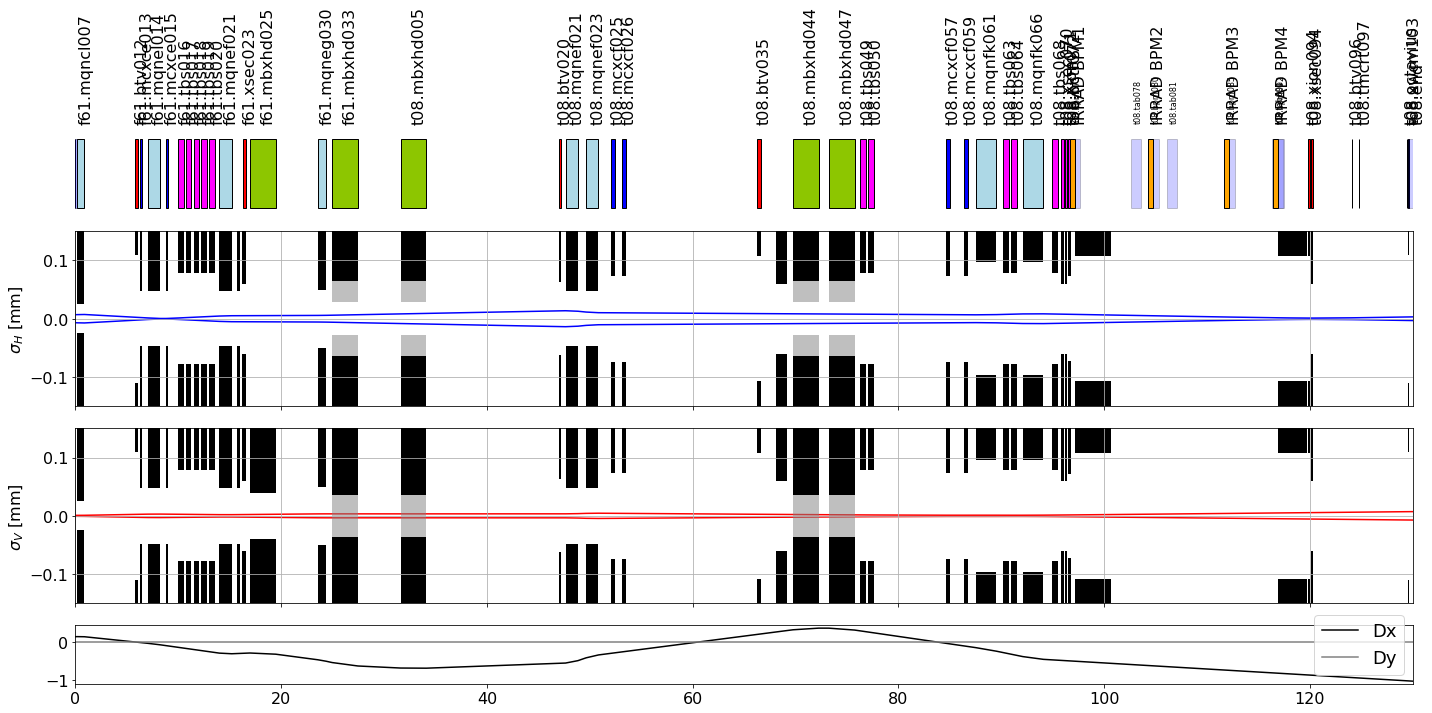

In [108]:
 fontsize = 16

fig, ax = plt.subplots(4,1, figsize=(20,10), tight_layout=True, sharex=True, height_ratios=[2,3,3,1])

draw_synoptic(ax[0], twiss)
ax[0].set_xlim(0,twiss.s[-1])
ax[0].set_ylim(-0.01,1.)
ax[0].axis("off")

ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)
ax[1].plot(twiss['s'], -beam_size(twiss['betx'], twiss['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)

ax[1].set_xlim(0,twiss.s[-1])

ax[2].plot(twiss['s'], beam_size(twiss['bety'], twiss['dy'], ey, sige, 1), alpha=1.0, color ="r", zorder=0)
ax[2].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 1), alpha=1.0, color ="r", zorder=0)

draw_aperture_circle(ax[1], twiss, "aper_1")
draw_aperture_circle(ax[2], twiss, "aper_1")
draw_aperture_rectangle(ax[1], twiss, "aper_1")
draw_aperture_rectangle(ax[2], twiss, "aper_2")
draw_aperture_racetrackH(ax[1], twiss, "aper_1", "aper_2", "aper_3", "aper_4")
draw_aperture_racetrackV(ax[2], twiss, "aper_1", "aper_2", "aper_3", "aper_4")

ax[2].set_xlim(0,twiss.s[-1])

ax[1].grid()
ax[1].set_ylim(-0.15, 0.15)
ax[1].set_ylabel(r"$\sigma_{H}$ [mm]", fontsize=fontsize)

ax[2].grid()
ax[2].set_ylim(-0.15, 0.15)
ax[2].set_ylabel(r"$\sigma_{V}$ [mm]", fontsize=fontsize)

ax[3].plot(twiss['s'], twiss['dx'], alpha=1.0, color ="k", zorder=0, label = "Dx")
ax[3].plot(twiss['s'], twiss['dy'], alpha=1.0, color ="gray", zorder=0, label = "Dy")
ax[3].legend()

In [109]:
0.18725*54/82

0.1233109756097561

In [110]:
0.030526*82/54

0.046354296296296296

# Creating a csv tables and calculating the Ks

In [111]:
df_filtered.type.iloc[0]

'Q200L'

In [112]:
print(start)
print(end)
print(selector)
print("")

d = {'name': [], 'type': [], 'current': []}
df_dipole_avg = pd.DataFrame(data=d)
print("Dipoles avg angle [rad]")
for name in df_dipoles.magnet_name.unique():
    df_filtered = df_dipoles[(df_dipoles.magnet_name == name) & (df_dipoles.type == "MCB")]
    if not df_filtered.empty:
        print(f"{name} {round(np.mean(df_filtered.angle),6)}")
        d = {'name': [name], 'type': [df_filtered.type.iloc[0]], 'current': [round(float(np.mean(df_filtered.VALUE)),2)]}
        df = pd.DataFrame(data=d)
        df_dipole_avg = pd.concat([df_dipole_avg,df])
        

d = {'name': [], 'type': [], 'current': []}
df_corrector_avg = pd.DataFrame(data=d)
print("")
print("Correctors avg angle [rad]")
for name in df_dipoles.magnet_name.unique():
    df_filtered = df_dipoles[(df_dipoles.magnet_name == name) & (df_dipoles.type != "MCB")]
    if not df_filtered.empty:
        print(f"{name} {round(np.mean(df_filtered.angle),6)}")
        d = {'name': [name], 'type': [df_filtered.type.iloc[0]], 'current': [round(float(np.mean(df_filtered.VALUE)),2)]}
        df = pd.DataFrame(data=d)
        df_corrector_avg = pd.concat([df_corrector_avg,df])

d = {'name': [], 'type': [], 'current': [],}
df_quadrupole_avg = pd.DataFrame(data=d)
print("")
print("Quadrupoles avg K1 [1/m^2]")
for name in df_quadrupoles.magnet_name.unique():
    df_filtered = df_quadrupoles[(df_quadrupoles.magnet_name == name)]
    print(f"{name} {round(np.mean(df_filtered.k1),6)}")
    d = {'name': [name], 'type': [df_filtered.type.iloc[0]], 'current': [round(float(np.mean(df_filtered.VALUE)),2)]}
    df = pd.DataFrame(data=d)
    df_quadrupole_avg = pd.concat([df_quadrupole_avg,df])
    
df_dipole_avg.set_index('name', inplace=True)
df_corrector_avg.set_index('name', inplace=True)
df_quadrupole_avg.set_index('name', inplace=True)

df_dipole_avg["Brho"] = np.ones(len(df_dipole_avg))*round(Brho,3)
df_dipole_avg["Bfield"] = np.ones(len(df_dipole_avg))*mean_flattop_Bfield
df_dipole_avg["energy"] = round((193.737692/208)*(np.sqrt(((1/((3.3356/(70.0789*54)*10000)/df_dipole_avg["Bfield"]))/193.737692)**2+1)-1),3)

df_corrector_avg["Brho"] = np.ones(len(df_corrector_avg))*round(Brho,3)
df_corrector_avg["Bfield"] = np.ones(len(df_corrector_avg))*mean_flattop_Bfield
df_corrector_avg["energy"] = round((193.737692/208)*(np.sqrt(((1/((3.3356/(70.0789*54)*10000)/df_corrector_avg["Bfield"]))/193.737692)**2+1)-1),3)

df_quadrupole_avg["Brho"] = np.ones(len(df_quadrupole_avg))*round(Brho,3)
df_quadrupole_avg["Bfield"] = np.ones(len(df_quadrupole_avg))*mean_flattop_Bfield
df_quadrupole_avg["energy"] = round((193.737692/208)*(np.sqrt(((1/((3.3356/(70.0789*54)*10000)/df_quadrupole_avg["Bfield"]))/193.737692)**2+1)-1),3)

2023-10-31 17:36:00.000
2023-10-31 17:40:00.000
CPS.USER.EAST3

Dipoles avg angle [rad]
F61.BHZ025.A/MEAS.PULSE 0.046353
F61.BHZ025.B/MEAS.PULSE 0.046353
F61.BHZ033.A/MEAS.PULSE 0.046913
F61.BHZ033.B/MEAS.PULSE 0.046913
T08.BHZ005/MEAS.PULSE 0.024551
T08.BHZ044/MEAS.PULSE 0.035843
T08.BHZ047/MEAS.PULSE 0.035679

Correctors avg angle [rad]
F61.DHZ013/MEAS.PULSE 0.0
F61.DVT015/MEAS.PULSE 0.0
T08.DHZ025/MEAS.PULSE 0.003149
T08.DVT057/MEAS.PULSE 0.000341
T08.DHZ059/MEAS.PULSE 0.001551

Quadrupoles avg K1 [1/m^2]
F61.QFN007/MEAS.PULSE 0.47959
F61.QDN014/MEAS.PULSE 0.138293
F61.QFN021/MEAS.PULSE 0.130811
F61.QDN030/MEAS.PULSE 0.059492
T08.QFN021/MEAS.PULSE 0.129207
T08.QDN023/MEAS.PULSE 0.128073
T08.QDN061/MEAS.PULSE 0.040416
T08.QFN066/MEAS.PULSE 0.045476


In [113]:
print(df_quadrupole_avg)
print(df_dipole_avg)
print(df_corrector_avg)

                        type  current    Brho  Bfield  energy
name                                                         
F61.QFN007/MEAS.PULSE   Q74L   370.06  49.071  7002.2     3.0
F61.QDN014/MEAS.PULSE  Q120C   197.18  49.071  7002.2     3.0
F61.QFN021/MEAS.PULSE    QFL   150.10  49.071  7002.2     3.0
F61.QDN030/MEAS.PULSE    QFS    66.75  49.071  7002.2     3.0
T08.QFN021/MEAS.PULSE    QFL   148.26  49.071  7002.2     3.0
T08.QDN023/MEAS.PULSE    QFL   146.96  49.071  7002.2     3.0
T08.QDN061/MEAS.PULSE  Q200L   107.47  49.071  7002.2     3.0
T08.QFN066/MEAS.PULSE  Q200L   120.89  49.071  7002.2     3.0
                        type  current    Brho  Bfield  energy
name                                                         
F61.BHZ025.A/MEAS.PULSE  MCB   180.00  49.071  7002.2     3.0
F61.BHZ025.B/MEAS.PULSE  MCB   180.00  49.071  7002.2     3.0
F61.BHZ033.A/MEAS.PULSE  MCB   182.22  49.071  7002.2     3.0
F61.BHZ033.B/MEAS.PULSE  MCB   182.22  49.071  7002.2     3.0
T08.BHZ0

## Compute the K

In [114]:
def apply_custom_k1(row):
    if row.name in ["F61.QDN02/MEAS.PULSE", "F61.QDN04/MEAS.PULSE", "T8.QDN06/MEAS.PULSE", "T8.QDN07/MEAS.PULSE"]:
        return round(-1 * k1(abs(row['current']), row['type'], row['Brho']), 6)
    else:
        return round(k1(abs(row['current']), row['type'], row['Brho']), 6)

df_quadrupole_avg['k1_stripped'] = df_quadrupole_avg.apply(apply_custom_k1, axis=1)
df_quadrupole_avg['k1_proton'] = df_quadrupole_avg['k1_stripped'].copy()  # Copy the values
df_quadrupole_avg['k1_proton'].iloc[1:] *= 82/54  # Multiply starting from the second row
df_quadrupole_avg['k1_proton'] =  round(df_quadrupole_avg['k1_proton'],6)

def apply_custom_k(row):
    if row.name in ["F61.BHZ01.A/MEAS.PULSE", "F61.BHZ01.B/MEAS.PULSE", "T8.BHZ04/MEAS.PULSE", "T8.BHZ05/MEAS.PULSE"]:
        return round(-1 * angle(abs(row['current']), row['type'], row['Brho']),6)
    else:
        return round(angle(abs(row['current']), row['type'], row['Brho']),6)

df_dipole_avg['k_stripped'] = df_dipole_avg.apply(apply_custom_k, axis=1)
df_dipole_avg['k_proton'] = df_dipole_avg['k_stripped'].copy()  # Copy the values
df_dipole_avg['k_proton'] *= 82/54  # Multiply starting from the second row
df_dipole_avg['k_proton'] =  round(df_dipole_avg['k_proton'],6)

def apply_custom_k_corrector(row):
    if row.current < 0:
        return round(-1 * angle(abs(row['current']), row['type'], row['Brho']),6)
    else:
        return round(angle(abs(row['current']), row['type'], row['Brho']),6)

df_corrector_avg['k_stripped'] = df_corrector_avg.apply(apply_custom_k_corrector, axis=1)
df_corrector_avg['k_proton'] = df_corrector_avg['k_stripped'].copy()  # Copy the values
df_corrector_avg['k_proton'] *= 82/54  # Multiply starting from the second row
df_corrector_avg['k_proton'] =  round(df_corrector_avg['k_proton'],6)


/tmp/ipykernel_571/1767521977.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_quadrupole_avg['k1_proton'].iloc[1:] *= 82/54  # Multiply starting from the second row
/tmp/ipykernel_571/1767521977.py:9: SettingWithCopyWarning: 
A value 

In [115]:
print(df_quadrupole_avg)
print(df_dipole_avg)
print(df_corrector_avg)

                        type  current    Brho  Bfield  energy  k1_stripped  \
name                                                                         
F61.QFN007/MEAS.PULSE   Q74L   370.06  49.071  7002.2     3.0     0.479590   
F61.QDN014/MEAS.PULSE  Q120C   197.18  49.071  7002.2     3.0     0.138290   
F61.QFN021/MEAS.PULSE    QFL   150.10  49.071  7002.2     3.0     0.130807   
F61.QDN030/MEAS.PULSE    QFS    66.75  49.071  7002.2     3.0     0.059491   
T08.QFN021/MEAS.PULSE    QFL   148.26  49.071  7002.2     3.0     0.129204   
T08.QDN023/MEAS.PULSE    QFL   146.96  49.071  7002.2     3.0     0.128072   
T08.QDN061/MEAS.PULSE  Q200L   107.47  49.071  7002.2     3.0     0.040415   
T08.QFN066/MEAS.PULSE  Q200L   120.89  49.071  7002.2     3.0     0.045474   

                       k1_proton  
name                              
F61.QFN007/MEAS.PULSE   0.479590  
F61.QDN014/MEAS.PULSE   0.209996  
F61.QFN021/MEAS.PULSE   0.198633  
F61.QDN030/MEAS.PULSE   0.090338  
T08.QFN02

# Export to csv

In [116]:
df_quadrupole_avg.to_csv("df_quadrupole_avg.csv", index=True)
df_dipole_avg.to_csv("df_dipole_avg.csv", index=True)
df_corrector_avg.to_csv("df_corrector_avg.csv", index=True)